# Crop data with yolo

In [1]:
%cd ../../..

/home/saplab/thaiminhpv/EFISS/AI-model-query-service


In [2]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

model = YOLO('torchscripts_models/yolo/yolov8n_12ep_24-7_32.5mAP.pt')
model.to('cuda:0')

In [3]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import os

df = pd.read_csv('data/shopee/shopee-data-for-training-filter-corrupted.csv')

In [4]:
df

,images,class_idx
0,data/shopee/product_images/shopee-thedelia/646...,24
1,data/shopee/product_images/shopee-thedelia/646...,24
2,data/shopee/product_images/shopee-thedelia/646...,24
3,data/shopee/product_images/shopee-thedelia/646...,24
4,data/shopee/product_images/shopee-22decembrest...,0
...,...,...
736035,data/shopee/product_images/shopee-4lova/6462d7...,31
736036,data/shopee/product_images/shopee-4lova/6462d7...,31
736037,data/shopee/product_images/shopee-4lova/6462d7...,31
736038,data/shopee/product_images/shopee-4lova/6462d7...,31


In [5]:
img = df.images.iloc[14]

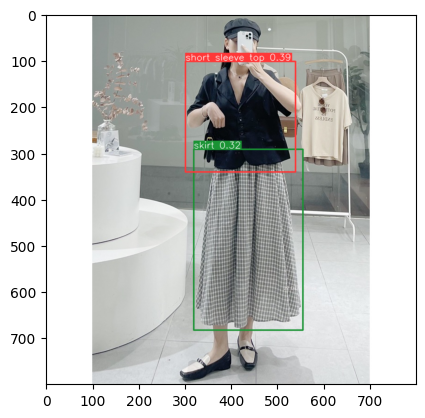

In [6]:
img = cv2.imread(img)
result = model.predict(
   source=img,
   conf=0.03,
   device='0',
   save=False,
   verbose=False
)[0]
plot = cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB)
plt.imshow(plot)

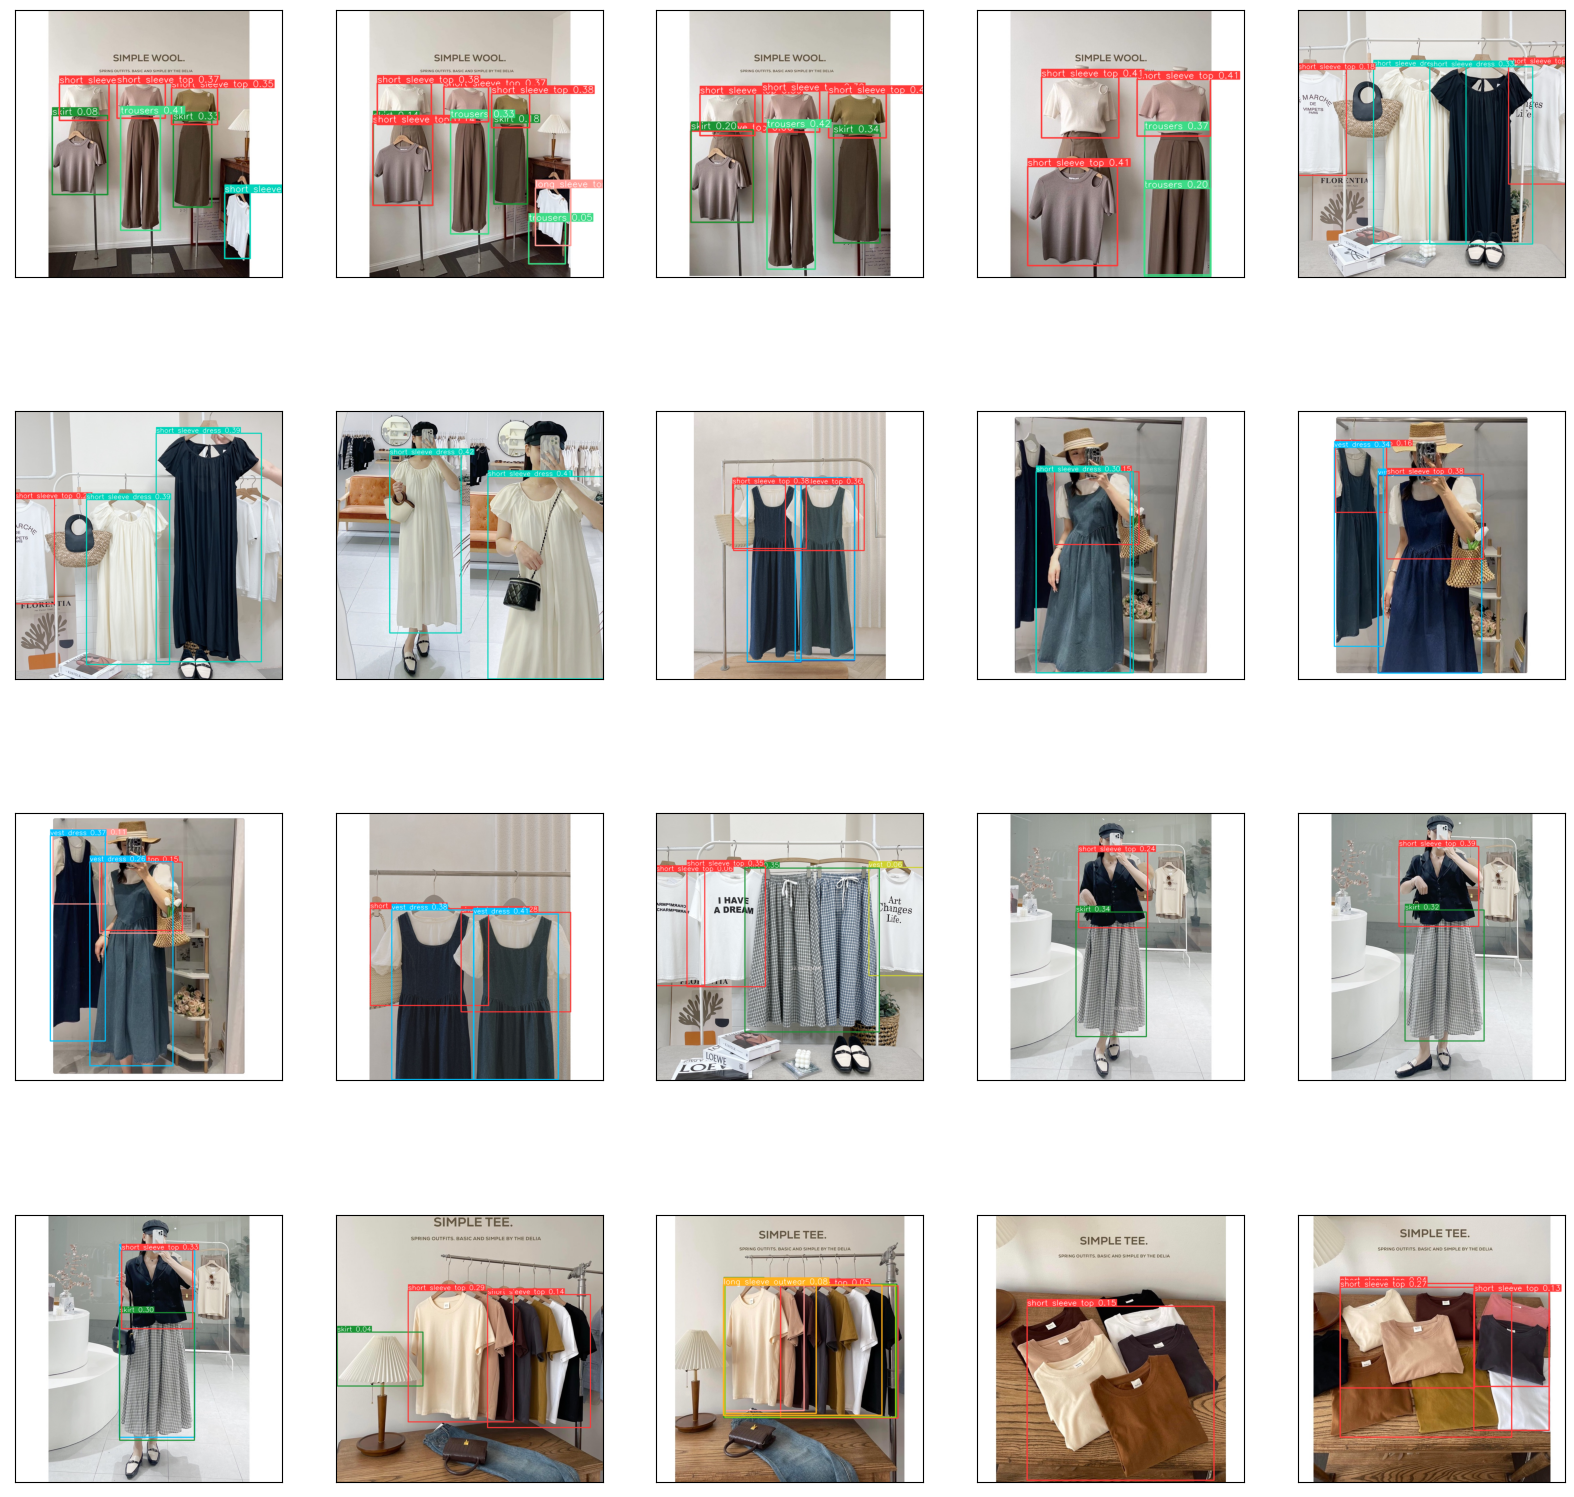

In [7]:
# plot first 20 images into grid
plt.figure(figsize=(20,20))
for i in range(20):
    # plt.subplot(7,9,i+1)
    plt.subplot(4,5,i+1)
    img = cv2.imread(df.images.iloc[i])
    img = model.predict(
        source=img,
        conf=0.03,
        device='0',
        save=False,
    )[0]
    plot = cv2.cvtColor(img.plot(), cv2.COLOR_BGR2RGB)
    plt.imshow(plot)
    plt.xticks([])
    plt.yticks([])
plt.show()


In [8]:
img.boxes.xyxy.shape

torch.Size([4, 4])

In [9]:
x,y, _x, _y = list(result.boxes.xyxy[1].int())

In [10]:
cropped = result.orig_img[y:_y, x:_x]

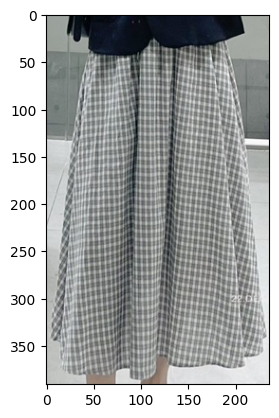

In [11]:
cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
plt.imshow(cropped)

In [12]:
for a in result.boxes.xyxy:
    print(a)

tensor([301.5110, 102.2728, 539.0721, 341.0175], device='cuda:0')
tensor([319.1157, 292.6389, 555.2831, 683.3493], device='cuda:0')


In [13]:
import numpy as np
# model = YOLO('yolov8n.pt')
# model = YOLO('trainer/runs/detect/train6/weights/best.pt')

def crop_image(img: np.ndarray) -> list[np.ndarray]:
    """
    Crop the image using YOLOv8
    
    Args:
        img (np.ndarray): the image to crop
    
    Returns:
        np.ndarray: the cropped image, or leave the image unchanged if no object is detected
    """
    result = model.predict(
        source=img,
        conf=0.03,
        device='0',
        save=False,
        verbose=False
    )[0]
    if len(result.boxes.xyxy) == 0:
        print("No object detected")
        return []
    
    out = []
    for box in result.boxes.xyxy:
        x, y, _x, _y = list(box.int())
        out.append(result.orig_img[y:_y, x:_x])
    
    return out

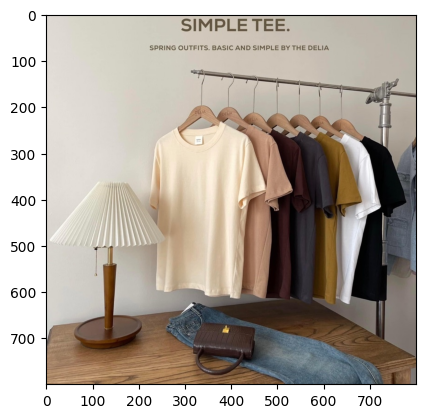

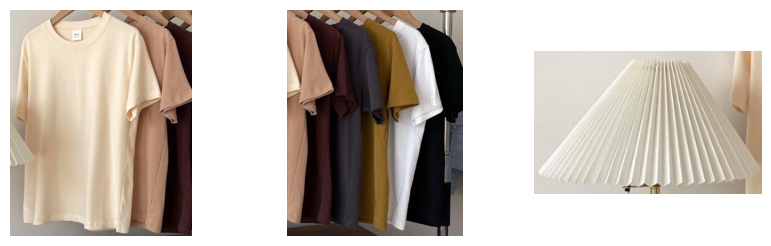

In [14]:
import matplotlib.pyplot as plt
img = df.images.iloc[16]
img = cv2.imread(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

c_img: list[np.ndarray] = crop_image(img)

plt.figure(figsize=(10, 10))
for i in range(len(c_img)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(c_img[i], cv2.COLOR_BGR2RGB))
    plt.axis("off")

In [15]:
df

,images,class_idx
0,data/shopee/product_images/shopee-thedelia/646...,24
1,data/shopee/product_images/shopee-thedelia/646...,24
2,data/shopee/product_images/shopee-thedelia/646...,24
3,data/shopee/product_images/shopee-thedelia/646...,24
4,data/shopee/product_images/shopee-22decembrest...,0
...,...,...
736035,data/shopee/product_images/shopee-4lova/6462d7...,31
736036,data/shopee/product_images/shopee-4lova/6462d7...,31
736037,data/shopee/product_images/shopee-4lova/6462d7...,31
736038,data/shopee/product_images/shopee-4lova/6462d7...,31


### batching make the image processing faster, but the dimension of the image must be the same -> not suitable for our case

In [16]:
# import torch

# # batching make the image processing faster, but the dimension of the image must be the same -> not suitable for our case

# def crop_images(img: list[torch.Tensor]) -> list[np.ndarray]:
#     """
#     Crop the image using YOLOv8
    
#     Args:
#         img (np.ndarray): the image to crop
    
#     Returns:
#         np.ndarray: the cropped image, or leave the image unchanged if no object is detected
#     """
#     results = model.predict(
#         source=img,
#         conf=0.03,
#         device='0',
#         save=False,
#         verbose=False
#     )
#     output = []
#     for result in results:
#         if len(result.boxes.xyxy) == 0:
#             print("No object detected")
#             return []
        
#         out = []
#         for box in result.boxes.xyxy:
#             x, y, _x, _y = list(box.int())
#             out.append(result.orig_img[y:_y, x:_x])
        
#         output.append(out)
    
#     output = np.array(output)
    
#     return output

# def crop_image_to_multiple_images_batched(image_path: str) -> list[str]:
#     """
#     Crop an image with YOLOv5 into multiple images. Return the paths of the cropped images.
#     """
#     img: np.ndarray = cv2.imread(image_path)
#     # img_extension: str = image_path.split(".")[-1]
#     img_name: str = image_path.split("/")[-1].split(".")[0]

#     cropped_images: list[np.ndarray] = crop_image(img)
#     cropped_image_paths: list[str] = []
#     for i, cropped_image in enumerate(cropped_images):
#         cropped_image_path: str = f"{output_datadir}/{img_name}_crop{i}.jpg"
#         cv2.imwrite(cropped_image_path, cropped_image)
#         cropped_image_paths.append(cropped_image_path)

#     return cropped_image_paths

# from torch.utils.data import Dataset, DataLoader

# class CustomDataset(Dataset):
#     def __init__(self, df):
#         self.df = df.images
    
#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         return cv2.imread(self.df.iloc[idx])

### Begin

In [17]:
import pandas as pd
import dask.dataframe as dd

In [18]:
_df = df

In [23]:
num_threads = 10
ddf = dd.from_pandas(_df, npartitions=num_threads)

pbar = tqdm(total=len(df))

output_datadir = "data/shopee_crop_yolo/images"
def crop_image_to_multiple_images(image_path: str) -> list[str]:
    """
    Crop an image with YOLOv5 into multiple images. Return the paths of the cropped images.
    """
    img: np.ndarray = cv2.imread(image_path)
    # img_extension: str = image_path.split(".")[-1]
    img_name: str = image_path.split("/")[-1].split(".")[0]

    try:
        cropped_images: list[np.ndarray] = crop_image(img)
    except Exception as e:
        print(f"Error cropping image {image_path}: {e}")

    cropped_image_paths: list[str] = []
    for i, cropped_image in enumerate(cropped_images):
        cropped_image_path: str = f"{output_datadir}/{img_name}_crop{i}.jpg"
        cv2.imwrite(cropped_image_path, cropped_image)
        cropped_image_paths.append(cropped_image_path)

    pbar.update(1)
    return cropped_image_paths

def df_crop_image(df: pd.DataFrame) -> pd.DataFrame:
    df['cropped_img_paths'] = df['images'].apply(crop_image_to_multiple_images)
    pbar.update(1)
    return df

# https://stackoverflow.com/questions/45545110/make-pandas-dataframe-apply-use-all-cores

# with pbar:
#     prep = ddf.map_partitions(df_crop_image, meta={'images': 'str', 'class_idx': np.int64, 'cropped_img_paths': 'str'})
#     res: pd.DataFrame = prep.compute(scheduler='threads')
#     res.to_csv("data/shopee_crop_yolo/cropped_images.csv", index=False)

  0%|          | 0/736040 [00:00<?, ?it/s]

In [ ]:
df['cropped_img_paths'] = df['images'].progress_apply(crop_image_to_multiple_images)
df.to_csv('data/shopee_crop_yolo/cropped_dataset.csv', index=False)

In [22]:
# df['cropped_img_paths'] = df['images'].progress_apply(crop_image_to_multiple_images)

# Create cropped dataset

In [1]:
%cd ../../..

/home/saplab/thaiminhpv/EFISS/AI-model-query-service


In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()

In [3]:
df = pd.read_csv('data/shopee_crop_yolo/cropped_dataset.csv')

In [5]:
df

,images,class_idx,cropped_img_paths
0,data/shopee/product_images/shopee-thedelia/646...,24,['data/shopee_crop_yolo/images/6460ab0252e3655...
1,data/shopee/product_images/shopee-thedelia/646...,24,['data/shopee_crop_yolo/images/6460ab0252e3655...
2,data/shopee/product_images/shopee-thedelia/646...,24,['data/shopee_crop_yolo/images/6460ab0252e3655...
3,data/shopee/product_images/shopee-thedelia/646...,24,['data/shopee_crop_yolo/images/6460ab0252e3655...
4,data/shopee/product_images/shopee-22decembrest...,0,['data/shopee_crop_yolo/images/6460aaee52e3655...
...,...,...,...
736035,data/shopee/product_images/shopee-4lova/6462d7...,31,['data/shopee_crop_yolo/images/6462d71a614eb20...
736036,data/shopee/product_images/shopee-4lova/6462d7...,31,['data/shopee_crop_yolo/images/6462d71a614eb20...
736037,data/shopee/product_images/shopee-4lova/6462d7...,31,['data/shopee_crop_yolo/images/6462d71a614eb20...
736038,data/shopee/product_images/shopee-4lova/6462d7...,31,['data/shopee_crop_yolo/images/6462d71a614eb20...


### Create dataset for deep hashing training

In [6]:
dh_df = df[['cropped_img_paths', 'class_idx']]
dh_df

,cropped_img_paths,class_idx
0,['data/shopee_crop_yolo/images/6460ab0252e3655...,24
1,['data/shopee_crop_yolo/images/6460ab0252e3655...,24
2,['data/shopee_crop_yolo/images/6460ab0252e3655...,24
3,['data/shopee_crop_yolo/images/6460ab0252e3655...,24
4,['data/shopee_crop_yolo/images/6460aaee52e3655...,0
...,...,...
736035,['data/shopee_crop_yolo/images/6462d71a614eb20...,31
736036,['data/shopee_crop_yolo/images/6462d71a614eb20...,31
736037,['data/shopee_crop_yolo/images/6462d71a614eb20...,31
736038,['data/shopee_crop_yolo/images/6462d71a614eb20...,31


In [7]:
import ast
dh_df.cropped_img_paths = dh_df.cropped_img_paths.apply(ast.literal_eval)
dh_df

/tmp/ipykernel_1526992/2880432763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dh_df.cropped_img_paths = dh_df.cropped_img_paths.apply(ast.literal_eval)


,cropped_img_paths,class_idx
0,[data/shopee_crop_yolo/images/6460ab0252e36550...,24
1,[data/shopee_crop_yolo/images/6460ab0252e36550...,24
2,[data/shopee_crop_yolo/images/6460ab0252e36550...,24
3,[data/shopee_crop_yolo/images/6460ab0252e36550...,24
4,[data/shopee_crop_yolo/images/6460aaee52e36550...,0
...,...,...
736035,[data/shopee_crop_yolo/images/6462d71a614eb205...,31
736036,[data/shopee_crop_yolo/images/6462d71a614eb205...,31
736037,[data/shopee_crop_yolo/images/6462d71a614eb205...,31
736038,[data/shopee_crop_yolo/images/6462d71a614eb205...,31


In [8]:
dh_df.cropped_img_paths.iloc[0]

['data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop0.jpg',
 'data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop1.jpg',
 'data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop2.jpg',
 'data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop3.jpg',
 'data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop4.jpg',
 'data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop5.jpg',
 'data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop6.jpg']

In [9]:
edh_df = dh_df.explode(column='cropped_img_paths')
edh_df

,cropped_img_paths,class_idx
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
...,...,...
736038,data/shopee_crop_yolo/images/6462d71a614eb2054...,31
736039,data/shopee_crop_yolo/images/6462d71a614eb2054...,31
736039,data/shopee_crop_yolo/images/6462d71a614eb2054...,31
736039,data/shopee_crop_yolo/images/6462d71a614eb2054...,31


In [10]:
edh_df.class_idx.value_counts()

0      117262
2       73637
1       66642
6       55445
3       54492
        ...  
257        84
268        84
266        82
265        70
261        58
Name: class_idx, Length: 271, dtype: int64

In [11]:
edh_df.cropped_img_paths.isna().sum()

42230

There are `42230` images that do not have any clothes, and there are still 272 classes left.

In [12]:
edh_df.dropna(subset=['cropped_img_paths'], inplace=True)

In [13]:
edh_df

,cropped_img_paths,class_idx
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
...,...,...
736038,data/shopee_crop_yolo/images/6462d71a614eb2054...,31
736039,data/shopee_crop_yolo/images/6462d71a614eb2054...,31
736039,data/shopee_crop_yolo/images/6462d71a614eb2054...,31
736039,data/shopee_crop_yolo/images/6462d71a614eb2054...,31


In [14]:
edh_df.class_idx.value_counts()

0      115169
2       72388
1       65026
6       54584
3       53642
        ...  
257        80
266        73
268        71
265        69
261        23
Name: class_idx, Length: 271, dtype: int64

In [15]:
edh_df

,cropped_img_paths,class_idx
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
0,data/shopee_crop_yolo/images/6460ab0252e365505...,24
...,...,...
736038,data/shopee_crop_yolo/images/6462d71a614eb2054...,31
736039,data/shopee_crop_yolo/images/6462d71a614eb2054...,31
736039,data/shopee_crop_yolo/images/6462d71a614eb2054...,31
736039,data/shopee_crop_yolo/images/6462d71a614eb2054...,31


In [19]:
with open('data/shopee_crop_yolo/database_info.txt', 'w') as f:
    for line in edh_df['cropped_img_paths']:
        f.write(line + '\n')

In [20]:
!head 'data/shopee_crop_yolo/database_info.txt'

data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop0.jpg
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop1.jpg
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop2.jpg
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop3.jpg
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop4.jpg
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop5.jpg
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop6.jpg
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_1_shopee_thedelia_crop0.jpg
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_1_shopee_thedelia_crop1.jpg
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_1_shopee_thedelia_crop2.jpg


In [40]:
database = edh_df
database.to_csv("data/shopee_crop_yolo/database.txt", index=False, header=False, sep=" ")

### Analyze classes that do not have any images left

In [26]:
l = dh_df.cropped_img_paths.apply(len)
l

0         7
1         8
2         7
3         5
4         4
         ..
736035    1
736036    1
736037    3
736038    2
736039    4
Name: cropped_img_paths, Length: 736040, dtype: int64

In [27]:
adh_df = dh_df.copy()
adh_df['len'] = adh_df['cropped_img_paths'].apply(len)
adh_df

,cropped_img_paths,class_idx,len
0,[data/shopee_crop_yolo/images/6460ab0252e36550...,24,7
1,[data/shopee_crop_yolo/images/6460ab0252e36550...,24,8
2,[data/shopee_crop_yolo/images/6460ab0252e36550...,24,7
3,[data/shopee_crop_yolo/images/6460ab0252e36550...,24,5
4,[data/shopee_crop_yolo/images/6460aaee52e36550...,0,4
...,...,...,...
736035,[data/shopee_crop_yolo/images/6462d71a614eb205...,31,1
736036,[data/shopee_crop_yolo/images/6462d71a614eb205...,31,1
736037,[data/shopee_crop_yolo/images/6462d71a614eb205...,31,3
736038,[data/shopee_crop_yolo/images/6462d71a614eb205...,31,2


In [28]:
t = adh_df[adh_df['len'] == 0]
t

,cropped_img_paths,class_idx,len
54,[],39,0
104,[],56,0
172,[],39,0
225,[],39,0
228,[],39,0
...,...,...,...
735606,[],31,0
735608,[],31,0
735640,[],12,0
735656,[],12,0


In [32]:
b = adh_df.drop(columns=['cropped_img_paths']).groupby('class_idx').sum()
b

,len
class_idx,
0,115169
1,65026
2,72388
3,53642
4,27003
...,...
267,157
268,71
269,222


In [34]:
(b['len'] == 0).sum()

0

Conclusion: All classes have at least some images that have clothes

### Now we create query set

In [57]:
# sample 1000 images from each class, if the class has less than 1000 images,
# we sample 
def sample(df):
    if len(df) > 1000:
        return df.sample(n=8)
    elif len(df) > 300:
        return df.sample(n=6)
    elif len(df) > 100:
        return df.sample(n=4)
    elif len(df) > 5:
        return df.sample(n=2)
    else:
        return df

In [58]:
test_df = database.groupby(['class_idx']).progress_apply(sample).reset_index(drop=True)

  0%|          | 0/271 [00:00<?, ?it/s]

In [59]:
test_df

,cropped_img_paths,class_idx
0,data/shopee_crop_yolo/images/64628cb3614eb2054...,0
1,data/shopee_crop_yolo/images/64627a6e614eb2054...,0
2,data/shopee_crop_yolo/images/64626a4f614eb2054...,0
3,data/shopee_crop_yolo/images/6462a2d4614eb2054...,0
4,data/shopee_crop_yolo/images/64624c31614eb2054...,0
...,...,...
1761,data/shopee_crop_yolo/images/646209939a89a085b...,270
1762,data/shopee_crop_yolo/images/6462a84f614eb2054...,271
1763,data/shopee_crop_yolo/images/6461eac2efa6e5631...,271
1764,data/shopee_crop_yolo/images/6461eac8efa6e5631...,271


In [60]:
test_df.cropped_img_paths.isna().sum()

0

In [61]:
test_df.to_csv('data/shopee_crop_yolo/test.txt', sep=' ', header=False, index=False)

In [62]:
!cat data/shopee_crop_yolo/database.txt | head

data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop0.jpg 24
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop1.jpg 24
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop2.jpg 24
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop3.jpg 24
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop4.jpg 24
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop5.jpg 24
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_0_shopee_thedelia_crop6.jpg 24
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_1_shopee_thedelia_crop0.jpg 24
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_1_shopee_thedelia_crop1.jpg 24
data/shopee_crop_yolo/images/6460ab0252e365505c04bdd6_1_shopee_thedelia_crop2.jpg 24
cat: write error: Broken pipe


In [63]:
!cat data/shopee_crop_yolo/test.txt | head

data/shopee_crop_yolo/images/64628cb3614eb2054535ba8f_0_shopee_myway_official_crop0.jpg 0
data/shopee_crop_yolo/images/64627a6e614eb20545358f14_2_shopee_maybi_fashion_crop0.jpg 0
data/shopee_crop_yolo/images/64626a4f614eb2054535283f_2_shopee_lovito_vn_crop0.jpg 0
data/shopee_crop_yolo/images/6462a2d4614eb2054536229d_0_shopee_tkfashion_mkt_crop0.jpg 0
data/shopee_crop_yolo/images/64624c31614eb20545348a09_3_shopee_emix_vn_crop0.jpg 0
data/shopee_crop_yolo/images/6462746f614eb2054535819d_3_shopee_lyrashop_vn_crop0.jpg 0
data/shopee_crop_yolo/images/64628cad614eb2054535ba6e_0_shopee_myway_official_crop0.jpg 0
data/shopee_crop_yolo/images/64624ad9614eb205453481e3_4_shopee_elise_official_crop1.jpg 0
data/shopee_crop_yolo/images/64626a91614eb20545352bed_5_shopee_lovito_vn_crop1.jpg 1
data/shopee_crop_yolo/images/6461dc7cefa6e56317bc8e1f_1_shopee_canifa_official_crop0.jpg 1
cat: write error: Broken pipe
